
# INFO 159/259
#<center> Homework 2: Featurized Models for Sentiment Analysis </center>

<center> Due: February 10, 2026 @ 11:59pm </center>

For this assignment, we provide an implementation of a simple binary classifier that will predict the sentiment of sentences from Yelp reviews based on a group of original features -- provided by you!

Before diving into any code, please read through the associated instructions for an overview of the assignment and specific instructions on how to submit.

### Assignment Overview and Learning Objectives

In this homework, you will
1. write code that generates features for the positive/negative sentiment classification of sentences from Yelp reviews
2. train a model on those features to predict the sentiment of new data.

During training, a basic logistic regression model (from the `scikit-learn` package) is trained with your
created features to predict each review's sentiment.

> Your ultimate goal for this assignment is to **featurize the text creatively** and **optimize the accuracy** of the model on the test data.

Your main tasks are to implement:

1. A bag of words feature. Fill out the `bag_of_words` function in the notebook to represent a document through its bag of words. Represent each **lowercase** word tokenized with the NLTK `word_tokenize` function through its binary value. Remember that the feature value for a word that shows up in a review should be 1, no matter how many times it is mentioned. Please keep your code between the `#BEGIN`/`#END SOLUTION` flags.

2. Create **three** different classes of features. Implement them in the `feature1`, `feature2`, and
`feature3` functions. Create features that you think would perform better than bag of words, and assess their independent performance on the development data. Describe your reasoning and include accuracy scores on the `dev.txt` data (printed in the Colab output). **You must report your reasoning and development scores in the table provided.**

It is not required that your features actually perform well, but your justification and reasoning should be defensible. We are looking for thoughtful insights as to why your original features should out-perform the simple bag of words implementation.

For more feature ideas consult [SLP Ch. 4](https://web.stanford.edu/~jurafsky/slp3/4.pdf) and lecture slides, and please do keep the following constraints
in mind:
- You should only change the code for `bag_of_words`, `feature1`, `feature2`, `feature3` and `combiner_function` along with any code you need to support those functions. You must use the classifier provided.
- You are free to use external dictionaries (such as LIWC or AFINN); if you use these, upload them to [Gradescope](https://www.gradescope.com/courses/1238346) as well with your `HW2.ipynb`.
- Do not use pre-trained word vectors (including static embeddings like word2vec or contextual
embeddings like BERT).
- Do not use the predictions of any other supervised model or LLM on this data as a feature for logistic regression (e.g., do not train a separate CNN on this data, make predictions on the dev data using the CNN, and then treat your CNN prediction as a feature).
- Do not alter `{train,dev,test}.txt` or find additional sources of training data. This homework
is focusing on how you represent your data, not other aspects of the training regime.
- Do not import any other additional libraries.

At the end of the notebook we've  included several other methods that you can use to interrogate your model; please feel free to use these to assess what kind of mistakes your current model is making in order to help brainstorm new features.

Once you've defined your features, described them, and evaluated their performance on the development data, it's time to make predictions on the test data. Adapt the `combiner_function` cell to include whichever features you like and execute it to make predictions on the test data. This will create the file `combiner_function_predictions.csv`; download this from Colab (using e.g. the file manager on the left panel) and submit it to [Gradescope](https://www.gradescope.com/courses/1238346), along with your `HW2.ipynb` and a pdf of the notebook.

In [1]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [4]:
import sys
!{sys.executable} -m nltk.downloader punkt_tab

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/abhishek_shukla/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Intro: Gather Data + Create Classifier

#### Gather Data

Let's download the data we'll use for training and development, and also the data we'll make predictions with.

In [6]:
# Get data
import urllib.request

files = [
    ("https://github.com/dbamman/nlp-course/raw/refs/heads/main/HW/data/train.txt", "train.txt"),
    ("https://github.com/dbamman/nlp-course/raw/refs/heads/main/HW/data/test.txt", "test.txt"),
    ("https://github.com/dbamman/nlp-course/raw/refs/heads/main/HW/data/dev.txt", "dev.txt")
]

for url, filename in files:
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filename)

print("All files downloaded!")

All files downloaded!


In [7]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

#### Define Classifier class

Next, we've created a Binary Classifier. This class will let us learn the traits associated with positive and negatively classed review sentences in order to make predictions on our test set.

In [10]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            reader = csv.reader(file, delimiter='\t')
            for row in reader:
                idd = row[0]
                label = row[1]
                text = row[2]

                data.append((idd, label, text))

        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    @ignore_warnings(category=ConvergenceWarning)
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

#### Simple Classifier example

Below is an example of select sentences with labels:
- `Positive` (pos): My last mani lasted almost a month with no chips.
- `Negative` (neg): We went tonight and are now kicking ourselves.

Let's create an initial classifier based on a really simple feature using a dictionary:

* if the abstract contains the words "love" or "like", the `contains_positive_word` feature will fire, and
* if it contains either "hate" or "dislike", the `contains_negative_word` will fire.  

Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words (the documentation for which can be found [here](https://www.nltk.org/api/nltk.tokenize.html)).

In [9]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1

    return feats

Now let's see how that feature performs on the development data.

Note the `L2_regularization_strength` parameter specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and `min_feature_count` specifies how many data points need to contain a feature for it to be passed into the model as a feature. Both are ways to prevent the model from overfitting and achieve higher performance.

In [11]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.596, Dev accuracy: 0.501


So we've created a classifier. But is its accuracy score any good?  Let's calculate the accuracy of a "majority classifier" to provide some context. This determines the most-represented (majority) class in the training data, and then predicts every test point to be this class.

In [13]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]

    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1

    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


The feature we created in `simple_featurize`, evidently, doesn't have a whole lot of legs. In the next portion of the homework, you'll be designing a few features of your own in the hopes of achieving the highest accuracy possible.

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm **3 additional** distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data.

<!-- Do not remove this comment, it is used by the autograder -->
<!-- Only modify the text within the placeholders [INSERT DESCRIPTION HERE]) -->


Describe your new features, one paragraph (around 50 words) each:   

**Bag of words (Example)**: The bag-of-words feature converts review text into binary indicators that signal the presence or absence of each word, without considering the order. This approach simplifies text representation, enabling the classifier to focus on distinguishing words for each review.


**Feature 1**: This has 5 variables using the Vader Sentiment Lexicon:    
                    `total_word_count`: Number of words (space separated) in the text; 
                    `pos_word_count`: Number of words with a positive score as per the dictionary; 
                    `neg_word_count`: Number of words with a negative score as per the dictionary; 
                    `pos_word_score`: Total Positive Score; 
                    `neg_word_score`: Total Negative Score

**Feature 2**: This has 2 variables:    
                    `num_punct`: Number of instances of the following Punctuations ?!(*$% in a review, I think this should separate reviews which have strong emphatic statements from others; 
                    `num_uppercase`: Number of words with all letters in upper case might be a proxy for emphatic words and statements

**Feature 3**: This has 1 variable:    
                    `num_negation`: Number of times any of the following words occur: "n't", "not", "but", "still", "although". This is a proxy for statements which might have variations in their tones

Now, implement the features in the specified `bag_of_words`, `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  Consider the type of data you are working with: what do you look for when writing/reading a review?

### Implement Bag-of-Words

In [306]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    """YOUR CODE HERE"""
    feats = {}
    # BEGIN SOLUTION
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word] = 1

    return feats
    # END SOLUTION

In [307]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

/Users/abhishek_shukla/Documents/Work/git_repo/nlp-course/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/abhishek_shukla/Documents/Work/git_repo/nlp-course/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/abhishek_shukla/Documents/Work/git_repo/nlp-course/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Method: bag_of_words, Features: 22970, Train accuracy: 0.848, Dev accuracy: 0.731


If you correctly implemented `bag_of_words`, you may expect a train accuracy of ~0.849 and a dev accuracy of ~0.732.

### Implement Original Features

In [261]:
def load_vader_dict(filename):
    """
    Converts vader sentiment dictionary text file into a dictionary
    """
    sentiment_dict = {}
    
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                splits = line.strip().split('\t')
                sentiment_dict[splits[0]] = float(splits[1])
            except:
                continue
    return sentiment_dict
                

In [262]:
sentiment_dict = load_vader_dict('vader_lexicon.txt')

In [263]:
sentiment_dict['meh']

-0.3

In [264]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    """YOUR CODE HERE"""
    # BEGIN SOLUTION
    feats = {}
    words = str.split(text)
    total_word_count = len(words)
    pos_word_count = 0
    neg_word_count = 0
    pos_word_score = 0
    neg_word_score = 0
    
    for word in words:
        try:
            # print('word', word)
            if(word.lower() in sentiment_dict.keys()):
                word = word.lower()
            if(sentiment_dict[word] > 0):
                pos_word_count += 1
                pos_word_score += sentiment_dict[word]
                # print('pos', pos_word_score)
            elif((sentiment_dict[word] < 0)|(sentiment_dict[word.lower()] < 0)):
                neg_word_count += 1
                neg_word_score += sentiment_dict[word]
            else:
                tokens = nltk.word_tokenize(word)
                for token in tokens:
                    if(token.lower() in sentiment_dict.keys()):
                        token = token.lower()
                    if(token in sentiment_dict.keys()):
                        if(sentiment_dict[token] > 0):
                            score_ = sentiment_dict[token]
                        elif(sentiment_dict[token] > 0):
                            score_ = sentiment_dict[token]
                        if(sentiment_dict[token] > 0):
                            pos_word_count += 1
                            pos_word_score += sentiment_dict[token]
                            # print('pos', pos_word_score)
                        elif(sentiment_dict[token] < 0):
                            neg_word_count += 1
                            neg_word_score += sentiment_dict[token]
                    # else:
                    #     if token in feats.keys():
                    #         feats[token] += 1
                    #     else:
                    #         feats[token] = 1
        except:
            tokens = nltk.word_tokenize(word)
            for token in tokens:
                if(token.lower() in sentiment_dict.keys()):
                    token = token.lower()
                if(token in sentiment_dict.keys()):
                    if(sentiment_dict[token] > 0):
                        pos_word_count += 1
                        pos_word_score += sentiment_dict[token]
                        # print('pos', pos_word_score)
                    elif(sentiment_dict[token] < 0):
                        neg_word_count += 1
                        neg_word_score += sentiment_dict[token]
                # else:
                #     if token in feats.keys():
                #         feats[token] += 1
                #     else:
                #         feats[token] = 1
            continue
    feats['total_word_count'] = total_word_count
    feats['pos_word_count'] = pos_word_count/total_word_count
    feats['neg_word_count'] = neg_word_count/total_word_count
    feats['pos_word_score'] = pos_word_score
    feats['neg_word_score'] = neg_word_score
        
    return feats
    # END SOLUTION

In [267]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 5, Train accuracy: 0.666, Dev accuracy: 0.637


In [291]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    """YOUR CODE HERE"""
    # BEGIN SOLUTION
    feats = {}
    tokens = nltk.word_tokenize(text)
    num_punct = 0
    num_uppercase = 0
    for token in tokens:
        if token in "?!(*$%":
            num_punct += 1    
        if token.isupper()==True:
            num_uppercase += 1
    feats['num_punct'] = num_punct
    feats['num_uppercase'] = num_uppercase
    return feats
    # END SOLUTION

In [292]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 2, Train accuracy: 0.594, Dev accuracy: 0.502


In [293]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.

    """YOUR CODE HERE"""
    # BEGIN SOLUTION
    feats = {}
    tokens = nltk.word_tokenize(text)
    num_negation = 0
    for token in tokens:
        token = token.lower()
        if token in ["n't", "not", "but", "still", "although"]:
            num_negation += 1    
    feats['num_negation'] = num_negation
    return feats
    # END SOLUTION

In [294]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 1, Train accuracy: 0.602, Dev accuracy: 0.517


## Deliverable 2

The two cells in "Combine your features" will generate a file named `combiner_function_predictions.csv`.

> Download this file (using the file manager on the left panel in Colab) and submit this to Gradescope along with your notebook.

Please do not change the auto-generated filename!

### Combine your features

Next, let's combine any or all the features you have developed into one big model and make predictions on the test data. There is no exact number/threshold we're looking for, accuracy-wise, but the combiner function should *generally* have a higher accuracy than BoW on its own (assuming your features are adding additional information beyond what BoW is adding).

You don't need to edit the following cell, unless you want to change which features are handed off to the "combined" model.

In [308]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.

    """YOUR CODE HERE"""
    all_feats={}
    # BEGIN SOLUTION
    all_feats = bag_of_words(text) | feature1(text) | feature2(text) | feature3(text)
    # all_feats = feature1(text) | feature2(text) | feature3(text)
    return all_feats
    # END SOLUTION

In [309]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate csv file with prediction output on test data
big_classifier.predict()

/Users/abhishek_shukla/Documents/Work/git_repo/nlp-course/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/abhishek_shukla/Documents/Work/git_repo/nlp-course/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/abhishek_shukla/Documents/Work/git_repo/nlp-course/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


Method: combiner_function, Features: 22978, Train accuracy: 0.850, Dev accuracy: 0.749


_We recommend that you download `combiner_function_predictions.csv` now in case your runtime gets disconnected._


## Further Exploration: Interrogating classifiers

Note: No deliverables are in this section; it's optional. Treat this portion as a useful tool for further understanding the features you worked on and how they affter the classifier.

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels). What kinds of mistakes is it making? (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well).

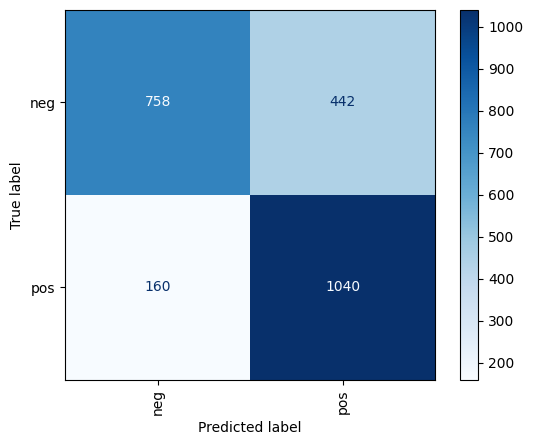

In [310]:
def print_confusion(classifier):
    cm = confusion_matrix(classifier.devY, classifier.log_reg.predict(classifier.devX))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.log_reg.classes_)
    disp.plot(xticks_rotation="vertical", values_format="d", cmap='Blues')
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most important for each of the classes (ranked by how strong their corresponding coefficient is). Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [311]:
big_classifier.printWeights(n=25)

pos	4.087	bomb
pos	2.752	killer
pos	2.346	pos_word_count
pos	2.215	die
pos	1.874	pita
pos	1.851	gem
pos	1.810	reasonable
pos	1.805	leftovers
pos	1.781	excited
pos	1.758	regrets
pos	1.705	fool
pos	1.688	reads
pos	1.627	decent
pos	1.626	devoured
pos	1.624	stuffed
pos	1.623	popping
pos	1.587	crown
pos	1.578	freak
pos	1.570	performing
pos	1.543	comfy
pos	1.510	frequently
pos	1.491	coma
pos	1.470	decide
pos	1.468	antibiotics
pos	1.460	butcher

neg	-2.446	neg_word_count
neg	-2.085	overpriced
neg	-2.052	lacking
neg	-1.980	bland
neg	-1.815	attitude
neg	-1.764	gripe
neg	-1.761	tiny
neg	-1.749	hesitant
neg	-1.748	drawback
neg	-1.748	beware
neg	-1.747	overwhelmed
neg	-1.742	undercooked
neg	-1.734	subpar
neg	-1.733	staffing
neg	-1.713	raw
neg	-1.710	improve
neg	-1.688	sketchy
neg	-1.680	kidding
neg	-1.678	sarcasm
neg	-1.649	harder
neg	-1.626	unfortunately
neg	-1.621	yeah
neg	-1.613	soggy
neg	-1.607	stale
neg	-1.605	nowhere



3. Next, let's look at the individual data points that are the hardest to classify correctly. Does it suggest any features you might create to disentangle them?

In [312]:
def analyze(classifier):

    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))

In [313]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,41483,0.994613,neg,pos,"He told me to give him a break, but as a customer I told him that it was his duty to fulfill the order I put in perfectly."
1,40495,0.990622,neg,pos,"But similar to other reviews, they pushed me right into the payment process as soon as I identified a pair of frames I liked."
2,40109,0.989659,neg,pos,"If you live there, you will have to do their job when it comes to maintenance if you want something fixed in a timely fashion."
3,41242,0.987908,neg,pos,I mean Google the thing for F sake and you will see many amazing ways of presenting this awesome dish!
4,42167,0.983419,neg,pos,"By the time his replacement steak was brought out sans hair, my plate was clean (minus the rock-tatoes) so he had to eat while I watched."
5,42068,0.978339,neg,pos,She was more than happy to oblige AND NEVER mentioned that it would cost us $98 extra - which is 50% more than the entire charge of the weekly rental!
6,41098,0.976513,pos,neg,"I must commend the management....a family of DB's came in with their little dogs....manager ""hey folks we can't have the dogs in here it's a restaurant"" I imagine there are health codes ect....DB's "" yeah we know, we are eating outside""????"
7,40712,0.975820,neg,pos,And the manager in the morning who was equally curt and offered to waive the charge off like she was doing us a favour!
8,41931,0.969472,neg,pos,"""Kobe Sliders"" at your local bar and grill for $12 have more in common with an aging basketball player than they do true Kobe Beef."
9,41858,0.969271,neg,pos,"Philly cheese steak was filled with some kind of ground-up meat, mixed with onions and (I think) green bell peppers, soaked in Cheese Whiz on a cold bun, with a cold order of fries."


### Closing and Submission

Congratulations on finishing HW2!

> For this homework, you will be able to see a leaderboard on Gradescope. This is **optional** (for fun) and to see how your featurized model may compare to your classmates! **You will still be graded on good effort**, not on an autograder criteria.



There are 3 deliverables, each to be submitted on [Gradescope](https://www.gradescope.com/courses/1238346):

1. **HW 2 Test Set Predictions**
- Submit the file `combiner_function_predictions.csv`. You can find files associated with the notebook if you click on the folder icon on the left-side panel of your Colab notebook. *Don't alter the file name.*
-  `Folder icon` (left panel) --> download `combiner_function_predictions.csv`

2. **HW 2 Code**
- Download your Colab notebook as an .ipynb file (
`File` --> `Download` --> `Download .ipynb`)
- Submit `HW2.ipynb`. *Don't alter the file name.*
- If you used any external dictionaries, please attach them as well.

3. **HW 2 PDF**
- If using Colab, you can use the cell below to generate a pdf.

Please ensure that you submit the predictions, completed notebook (notebook and pdf), and any external dictionaries used onto [Gradescope](https://www.gradescope.com/courses/1238346) before February 10 at 11:59pm.  The notebook you upload to [Gradescope](https://www.gradescope.com/courses/1238346) must be named `HW2.ipynb`.

In [240]:
#EXPORT_EXCLUDE#

#@markdown This is a helper function to generate a PDF in Colab.
#@markdown If you are using Jupyter notebook, you can do `File > Save and Export Notebook as HTML`, then save the resulting HTML file as a PDF.
#@markdown Alternatively, in Juypter notebook, you might try `File > Save and Export Notebook as PDF`, but just make sure you already have `pandoc` installed.

def colab_export_pdf():
    # Modified from: https://medium.com/@jonathanagustin/convert-colab-notebook-to-pdf-0ccd8f847dd6
    try:
        import google.colab
        IN_COLAB = True
    except:
        IN_COLAB = False
        print("This cell only works in Google Colab!")
        print("If you are running locally, click File > Export as HTML. Then open the HTML file and save it as a PDF.")

    if IN_COLAB:
        print("Generating PDF. This may take a few seconds.")
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

colab_export_pdf()

This cell only works in Google Colab!
If you are running locally, click File > Export as HTML. Then open the HTML file and save it as a PDF.
